<a href="https://colab.research.google.com/github/4d5645/StatsForDataAnalysis_MIPT/blob/main/Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis in the problem of credit scoring

In [19]:
%pylab inline
import pandas as pd
import numpy as np
import scipy
import math
import statsmodels
from scipy import stats
import matplotlib.pyplot as plt
import warnings
from itertools import product
from statsmodels.sandbox.stats.multicomp import multipletests
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [20]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MIPT/credit_card_default_analysis.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


- LIMIT_BAL: the size of the credit limit (including for the client's family)
- GENDER: customer gender (1 = male, 2 = female)
- EDUCATION: Education (0=Doctor, 1=Master; 2=Bachelor; 3=High School Graduate; 4=Primary Education; 5=Other; 6=N/A).
- MARRIAGE: (0=withhold consent; 1=married/married; 2=single; 3=not available).
- AGE: age
- PAY_0 - PAY_6 : History of past loan payments. PAY_6 - payment in September, ... Pay_0 - payment in September. Payment = (0 = good payment, 1=one month late, 2=2 months late...)
- BILL_AMT1 - BILL_AMT6: debt, BILL_AMT6 - for April, BILL_AMT1 - for September
- PAY_AMT1 - PAY_AMT6: amount paid in PAY_AMT6 - earlier, ..., PAY_AMT1 - September
- by default - non-refund indicator

In [21]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0



# Credit limit size (LIMIT_BAL).

 Dividing the dataset into people who returned and did not return the loan.

In [22]:
rtrn = data[data.default == 0]
not_rtrn = data[data.default == 1]

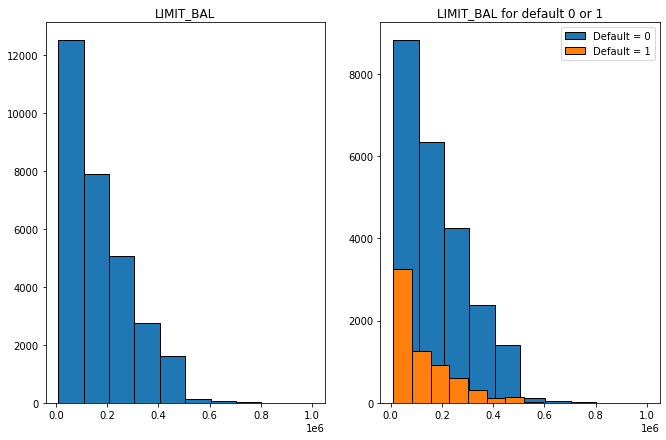

In [23]:
#SEX distribution
plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title('LIMIT_BAL')
plt.hist(data['LIMIT_BAL'], edgecolor='k')
plt.subplot(122)
plt.title('LIMIT_BAL for default 0 or 1')
plt.hist(rtrn.LIMIT_BAL, label='Default = 0', edgecolor='k')
plt.hist(not_rtrn.LIMIT_BAL, label='Default = 1', edgecolor='k')
plt.legend()

### Let's test the hypothesis about the equality of the median values ​​of the credit limit using a suitable interval estimate

H0: median values ​​are equal

H1: median values ​​are different

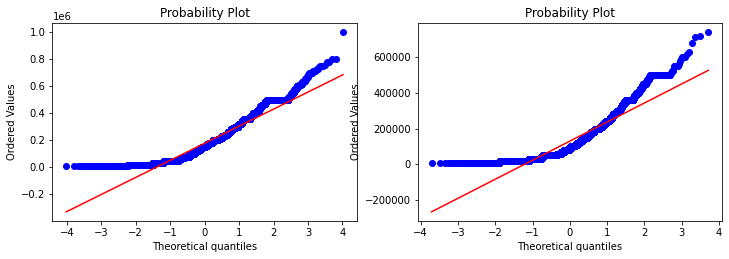

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(rtrn.LIMIT_BAL, dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(not_rtrn.LIMIT_BAL, dist="norm", plot=plt)
plt.show()

Distribution is different from normal.

In [25]:
# point estimate of the medians
print(f'For those who returned: {rtrn.LIMIT_BAL.median()}')
print(f'For those who did not return: {not_rtrn.LIMIT_BAL.median()}')

For those who returned: 150000.0
For those who did not return: 90000.0


In [26]:
# bootstrap estimate of the medians
def get_bootstrap_samples(data, n_samples):
  indices = np.random.randint(0, len(data), (n_samples, len(data)))
  samples = data[indices]
  return samples

def stat_intervals(stat, alpha):
  boundaries = np.percentile(stat, [100 * alpha / 2., 100 *(1 - alpha / 2.)])
  return boundaries

np.random.seed(0)
rtrn_median_scores = np.array(list(map(np.median, get_bootstrap_samples(rtrn.LIMIT_BAL.to_numpy(), 1000))))
not_rtrn_median_scores = np.array(list(map(np.median, get_bootstrap_samples(not_rtrn.LIMIT_BAL.to_numpy(), 1000))))
print('95% confidence interval for those who returned', stat_intervals(rtrn_median_scores, 0.05))
print('95% confidence interval for those who did not return', stat_intervals(not_rtrn_median_scores, 0.05))

95% confidence interval for those who returned [150000. 150000.]
95% confidence interval for those who did not return [80000. 90000.]


Median values ​​differ significantly. Confidence intervals do not overlap.
### Let's test the hypothesis of equality of distributions using one of the appropriate nonparametric criteria for checking the equality of means



H0: sample distributions are completely equal

H1: sample distributions differ by the amount of shift

In [27]:
# the Mann-Whitney Rank Test
stats.mannwhitneyu(rtrn.LIMIT_BAL, not_rtrn.LIMIT_BAL)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

P-value is very small, the null hypothesis is strongly rejected.

The result is practically significant, as the model will see the relationship between the median value and credit history.

# Gender (SEX)

### Let's test the hypothesis that the gender composition of the group of people who repaid and did not repay the loan is different

In [28]:
women = data[data.SEX == 2]
men = data[data.SEX == 1]

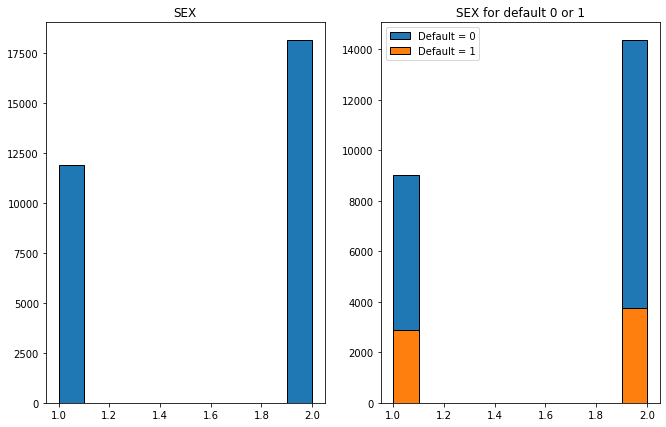

In [29]:
#SEX distribution
plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title('SEX')
plt.hist(data['SEX'], edgecolor='k')
plt.subplot(122)
plt.title('SEX for default 0 or 1')
plt.hist(rtrn.SEX, label='Default = 0', edgecolor='k')
plt.hist(not_rtrn.SEX, label='Default = 1', edgecolor='k')
plt.legend()

We can see that women are more likely to default on loans than men.

Let's apply Wilson's interval estimation for each value from the graph above.

In [30]:
from statsmodels.stats.proportion import proportion_confint
print('95%% confidence interval for men, that did not return loans', proportion_confint(men.default.sum(), men.default.shape[0], method = 'wilson'))
print('95%% confidence interval for women, that did not return loans', proportion_confint(women.default.sum(), women.default.shape[0], method = 'wilson'))

95%% confidence interval for men, that did not return loans (0.2340610359763117, 0.24945040997857762)
95%% confidence interval for women, that did not return loans (0.20191659085963207, 0.21373296513459847)



Confidence intervals do not overlap, it is very likely that the difference is significant in the percentage of repaid loans depending on gender.

Let's construct a confidence interval for the difference between two fractions of independent samples.



In [31]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)
print('95%% confidence interval for a difference between proportions', proportions_diff_confint_ind(men.default, women.default))

95%% confidence interval for a difference between proportions (0.024207372179792706, 0.0436115585708172)



The interval is shifted to the right and does not contain zero.

Now let's use the statistical Z-test for the proportion for two independent samples.

H0: gender composition does not differ

H1: gender composition is different

In [32]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

print("p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(men.default, women.default), 'greater'))


p-value:  2.2364332608049153e-12



The hypothesis of equality of gender distribution is rejected.

The result is practically significant, since it allows the model to learn a new dependence.

# Education (EDUCATION)
### Let's test the hypothesis that education does not affect whether a person repays a debt.

H0: No relationship between education level and default

H1: H0 is not correct

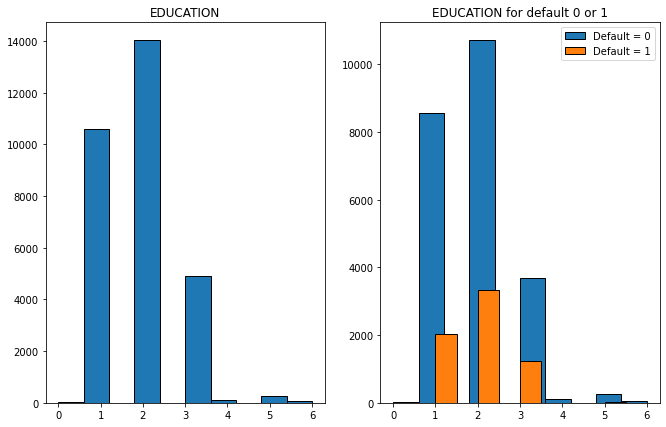

In [33]:
#Education distribution
plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title('EDUCATION')
plt.hist(data['EDUCATION'], edgecolor='k')
plt.subplot(122)
plt.title('EDUCATION for default 0 or 1')
plt.hist(rtrn.EDUCATION, label='Default = 0', edgecolor='k')
plt.hist(not_rtrn.EDUCATION, label='Default = 1', edgecolor='k')
plt.legend()

We have an uneven distribution of people according to the degree of education.

Let's make a contingency table "education" and "debt repayment", where the value of the cell would be the difference between the observed and expected number of people.

In [34]:
# level - the difference between those who returned and those who did not return - total number of people
difference = []
for level in range(0,7):
    diff = data[(data.EDUCATION == level) & (data.default == 0)].shape[0] - data[(data.EDUCATION == level) & (data.default == 1)].shape[0]
    difference = np.append(difference, diff)
    print(level, diff, data[(data.EDUCATION == level)].shape[0])

0 14 14
1 6513 10585
2 7370 14030
3 2443 4917
4 109 123
5 244 280
6 35 51


Let's perform normalization by dividing the difference by the total number of people who received a loan in the group under consideration.

In [35]:
difference = []
for level in range(0,7):
    diff = 1.*(data[(data.EDUCATION == level) & (data.default == 0)].shape[0] ) / data[(data.EDUCATION == level) ].shape[0]
    difference = np.append(difference, diff)
    print(level, diff)

0 1.0
1 0.8076523382144544
2 0.7626514611546685
3 0.7484238356721579
4 0.943089430894309
5 0.9357142857142857
6 0.8431372549019608


0 and 4 types of training have the highest probability of returning the loan. The least likely is type 2.


Next we created a matrix, where the first row is those people who did not repay the loan, and the second is those who did.


In [97]:
frst = []
scnd = []
for first in range(0,7):
  frst.append(data[(data.EDUCATION == first) & (data.default == 1)].shape[0])
for second in range(0,7):
  scnd.append(data[(data.EDUCATION == second) & (data.default == 0)].shape[0])
confusion_matrix = np.column_stack((frst, scnd)).transpose()
print(confusion_matrix)
def cramers_stat(confusion_matrix): 
    chi2 = scipy.stats.chi2_contingency(confusion_matrix, correction= True)[0]
    n = confusion_matrix.sum() 
    return np.sqrt(1.*chi2 / (n*(min(confusion_matrix.shape)-1))) 

print("Cramer V: ", cramers_stat(confusion_matrix), "p-value: ", scipy.stats.chi2_contingency(confusion_matrix, correction= True)[1])

[[    0  2036  3330  1237     7    18     8]
 [   14  8549 10700  3680   116   262    43]]
Cramer V:  0.07376009713252162 p-value:  1.2332626245415958e-32


Null hypothesis is rejected, Cramer's V value is 0.07

# Marital status (MARRIAGE)
### Let's check how marital status is related to the default indicator.

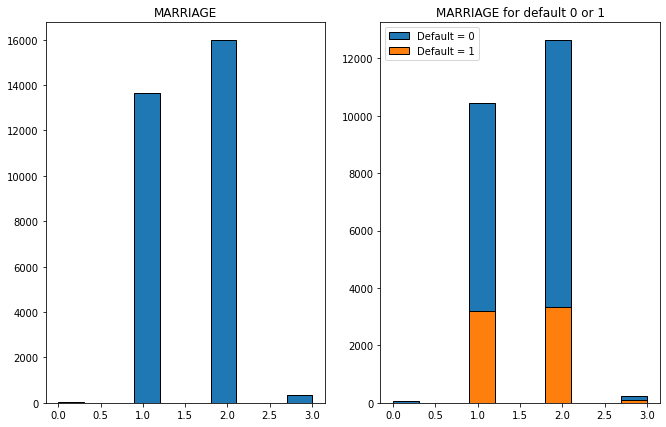

In [96]:
#Marital status distribution
plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title('MARRIAGE')
plt.hist(data['MARRIAGE'], edgecolor='k')
plt.subplot(122)
plt.title('MARRIAGE for default 0 or 1')
plt.hist(rtrn.MARRIAGE, label='Default = 0', edgecolor='k')
plt.hist(not_rtrn.MARRIAGE, label='Default = 1', edgecolor='k')
plt.legend()

Again we created a matrix, where the first row is those people who did not repay the loan, and the second is those who did.

And we counted Cramer's V coefficient.

In [100]:
frst = []
scnd = []
for first in range(0,4):
  frst.append(data[(not_rtrn.MARRIAGE == first) & (data.default == 1)].shape[0])
for second in range(0,4):
  scnd.append(data[(data.MARRIAGE == second) & (data.default == 0)].shape[0])
confusion_matrix = np.column_stack((frst, scnd)).transpose()
print(confusion_matrix)
def cramers_stat(confusion_matrix): 
    chi2 = scipy.stats.chi2_contingency(confusion_matrix, correction= True)[0]
    n = confusion_matrix.sum() 
    return np.sqrt(1.*chi2 / (n*(min(confusion_matrix.shape)-1))) 

print("Cramer V: ", cramers_stat(confusion_matrix), "p-value: ", scipy.stats.chi2_contingency(confusion_matrix, correction= True)[1])

[[    5  3206  3341    84]
 [   49 10453 12623   239]]
Cramer V:  0.034478203662766466 p-value:  8.825862457577375e-08



Cramer's coefficient shows that there is no relationship.

There is practical significance in this information, since the model will know that there is no correlation between marital status and default.

# Age (AGE)

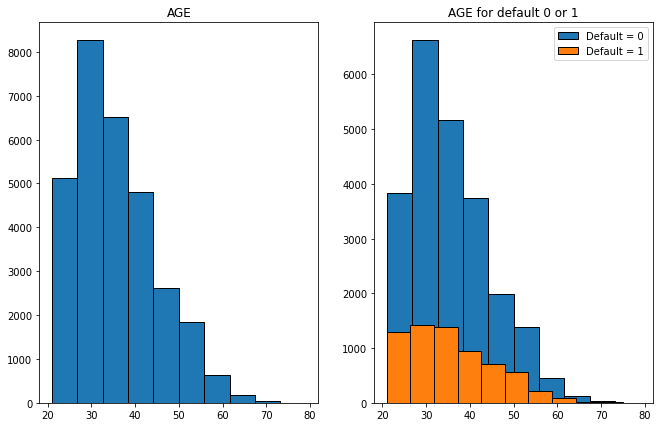

In [101]:
#Age distribution
plt.figure(figsize=(11,7))
plt.subplot(121)
plt.title('AGE')
plt.hist(data['AGE'], edgecolor='k')
plt.subplot(122)
plt.title('AGE for default 0 or 1')
plt.hist(rtrn.AGE, label='Default = 0', edgecolor='k')
plt.hist(not_rtrn.AGE, label='Default = 1', edgecolor='k')
plt.legend()

### Let's test the hypothesis about the equality of the median values ​​of people's ages
H0: median values ​​are equal

H1: median values ​​are different

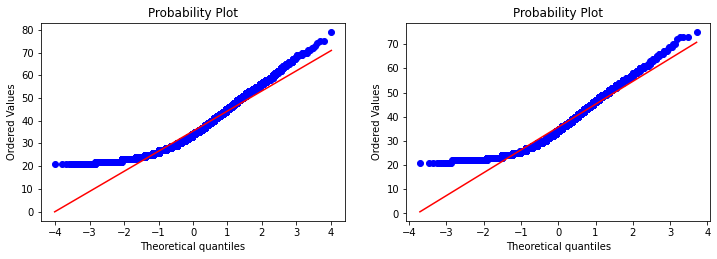

In [104]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(rtrn.AGE, dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(not_rtrn.AGE, dist="norm", plot=plt)
plt.show()

Distribution is different from normal.

In [102]:
# point estimate of the medians
print(f'For those who returned: {rtrn.AGE.median()}')
print(f'For those who did not return: {not_rtrn.AGE.median()}')

For those who returned: 34.0
For those who did not return: 34.0


In [103]:
# bootstrap estimate of the medians
def get_bootstrap_samples(data, n_samples):
  indices = np.random.randint(0, len(data), (n_samples, len(data)))
  samples = data[indices]
  return samples

def stat_intervals(stat, alpha):
  boundaries = np.percentile(stat, [100 * alpha / 2., 100 *(1 - alpha / 2.)])
  return boundaries

np.random.seed(0)
rtrn_median_scores = np.array(list(map(np.median, get_bootstrap_samples(rtrn.AGE.to_numpy(), 1000))))
not_rtrn_median_scores = np.array(list(map(np.median, get_bootstrap_samples(not_rtrn.AGE.to_numpy(), 1000))))
print('95% confidence interval for those who returned', stat_intervals(rtrn_median_scores, 0.05))
print('95% confidence interval for those who did not return', stat_intervals(not_rtrn_median_scores, 0.05))

95% confidence interval for those who returned [34. 34.]
95% confidence interval for those who did not return [34. 35.]



As can be seen from the interval estimate, the interval estimates for the median intersect. Let's construct a confidence interval for the difference between two fractions of independent samples.


In [110]:
print('median for those who returned: ', sum(rtrn_median_scores) / float(len(rtrn.AGE)))
print('median for those who did not return: ', sum(not_rtrn_median_scores) / float(len(not_rtrn.AGE)))

delta_median_scores = np.array(list(map(lambda x: x[0] - x[1], zip(rtrn_median_scores, not_rtrn_median_scores))))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

median for those who returned:  1.4552302687895908
median for those who did not return:  5.136904761904762
95% confidence interval for the difference between medians [-1.  0.]


The confidence interval contains zero, the median values ​​do not differ.

### Let's test the hypothesis about the equality of distributions using one of the appropriate nonparametric criteria for checking the equality of means.

H0: sample distributions are completely equal

H1: sample distributions differ by the amount of shift

In [115]:
# permutation criterion for independent samples
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]
  
def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample1, sample2, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

print('p-value:', permutation_test(rtrn.AGE, not_rtrn.AGE, max_permutations=1000))

p-value: 0.008



The p-value is small and the null hypothesis is rejected.


This result is also practically significant, because these data can be taken into account when issuing a loan.